# Football players tracking with YOLOv5 + ByteTrack

## About

In this tutorial, we will utilize an open source computer vision dataset from one of the 100,000+ available on [Roboflow Universe](https://universe.roboflow.com/).

If you already have your own images (and, optionally, annotations), you can convert your dataset using Roboflow, a set of tools developers use to build better computer vision models quickly and accurately. 150k+ developers use roboflow for (automatic) annotation, converting dataset formats (like to YOLOv5), training, deploying, and improving their datasets/models.

**Usefull links:**

- [YOLOv5 repository](https://github.com/ultralytics/yolov5)
- [ByteTrack repository](https://github.com/ifzhang/ByteTrack)
- [Roboflow Notebooks](https://github.com/roboflow-ai/notebooks)

## Table of content:
* [Setup](#setup)
* [Download data](#download-data)
* [Install YOLOv5](#install-yolov5)
* [Install ByteTrack and other libs](#install-bytetrack)
* [Custom annotator](#custom-annotator)
* [Detect ball possession](#detect-ball-possession)
* [Full video tracking](#full-video-tracking)
* [Put everything together](#put-everything-together)




## Setup <a class="anchor" id="setup"></a>

In [5]:
import subprocess

def get_gpu_info():
    try:
        output = subprocess.check_output(["system_profiler", "SPDisplaysDataType"])
        output = output.decode("utf-8")
        print(output)
    except subprocess.CalledProcessError as e:
        print("Error:", e)

get_gpu_info()


Graphics/Displays:

    Apple M1:

      Chipset Model: Apple M1
      Type: GPU
      Bus: Built-In
      Total Number of Cores: 7
      Vendor: Apple (0x106b)
      Metal Support: Metal 3
      Displays:
        Color LCD:
          Display Type: Built-In Retina LCD
          Resolution: 2560 x 1600 Retina
          Main Display: Yes
          Mirror: Off
          Online: Yes
          Automatically Adjust Brightness: Yes
          Connection Type: Internal




In [2]:
import os
HOME = os.getcwd()
print(HOME)

/Users/sakshambehal/Documents/Research_Papers


## Download data <a class="anchor" id="download-data"></a>

In [3]:
!pip install kaggle --upgrade --quiet

We will use [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout/data) from Kaggle. We can download it using [Kaggle API](https://github.com/Kaggle/kaggle-api). According to documentation we need to set up two environment variables first: 

```
export KAGGLE_USERNAME=datadinosaur
export KAGGLE_KEY=xxxxxxxxxxxxxx
```

In [4]:
import os
from getpass import getpass

In [5]:
os.environ['KAGGLE_USERNAME'] = getpass('Enter KAGGLE_USERNAME secret value: ')
os.environ['KAGGLE_KEY'] = getpass('Enter KAGGLE_KEY secret value: ')

Enter KAGGLE_USERNAME secret value:  ········
Enter KAGGLE_KEY secret value:  ········


In [6]:
!kaggle competitions files -c dfl-bundesliga-data-shootout | grep clips | head -10

clips/08fd33_2.mp4      21MB  2022-07-29 14:23:09  
clips/08fd33_9.mp4      18MB  2022-07-29 14:23:09  
clips/0a2d9b_9.mp4      18MB  2022-07-29 14:23:09  
clips/08fd33_3.mp4      17MB  2022-07-29 14:23:09  
clips/08fd33_6.mp4      19MB  2022-07-29 14:23:09  
clips/08fd33_0.mp4      19MB  2022-07-29 14:23:09  
clips/0a2d9b_5.mp4      18MB  2022-07-29 14:23:09  
clips/08fd33_7.mp4      18MB  2022-07-29 14:23:09  
clips/0a2d9b_0.mp4      20MB  2022-07-29 14:23:09  
clips/0a2d9b_7.mp4      19MB  2022-07-29 14:23:09  


In [8]:
%cd {HOME}
!kaggle competitions files -c dfl-bundesliga-data-shootout | \
grep clips | head -20 | \
awk '{print $1}' | \
while read -r line; \
  do kaggle competitions download -c dfl-bundesliga-data-shootout -f $line -p clips --quiet; \
  unzip ${line}.zip -d clips && rm ${line}.zip; \
  done

/Users/sakshambehal/Documents/Research_Papers
Archive:  clips/08fd33_2.mp4.zip
  inflating: clips/08fd33_2.mp4      
Archive:  clips/08fd33_9.mp4.zip
  inflating: clips/08fd33_9.mp4      
Archive:  clips/0a2d9b_9.mp4.zip
  inflating: clips/0a2d9b_9.mp4      
Archive:  clips/08fd33_3.mp4.zip
  inflating: clips/08fd33_3.mp4      
Archive:  clips/08fd33_6.mp4.zip
  inflating: clips/08fd33_6.mp4      
Archive:  clips/08fd33_0.mp4.zip
  inflating: clips/08fd33_0.mp4      
Archive:  clips/0a2d9b_5.mp4.zip
  inflating: clips/0a2d9b_5.mp4      
Archive:  clips/08fd33_7.mp4.zip
  inflating: clips/08fd33_7.mp4      
Archive:  clips/0a2d9b_0.mp4.zip
  inflating: clips/0a2d9b_0.mp4      
Archive:  clips/0a2d9b_7.mp4.zip
  inflating: clips/0a2d9b_7.mp4      
Archive:  clips/08fd33_1.mp4.zip
  inflating: clips/08fd33_1.mp4      
Archive:  clips/0a2d9b_2.mp4.zip
  inflating: clips/0a2d9b_2.mp4      
Archive:  clips/0a2d9b_1.mp4.zip
  inflating: clips/0a2d9b_1.mp4      
Archive:  clips/08fd33_4.mp4.zi

## Install YOLOv5 <a class="anchor" id="install-yolov5"></a>

### Use pre-trained COCO model - full video

In [10]:
%cd {HOME}/yolov5
!python detect.py --weights yolov5x.pt --img 640 --conf 0.25 --source {HOME}/clips/08fd33_4.mp4 --name coco

/Users/sakshambehal/Documents/Research_Papers/yolov5
detect: weights=['yolov5x.pt'], source=/Users/sakshambehal/Documents/Research_Papers/clips/08fd33_4.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=coco, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.11.7 torch-2.2.1 CPU

100%|████████████████████████████████████████| 166M/166M [01:37<00:00, 1.79MB/s]

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
video 1/1 (1/750) /Users/sakshambehal/Documents/Research_Papers/clips/08fd33_4.mp4: 384x640 25 persons, 1 sports ball, 1440.0ms
video 1/1 (2/750) /Users/sakshambehal/Documents/Research_Papers/cli

In [10]:
# %cd {HOME}/yolov5
# !python detect.py --weights yolov5x6.pt --img 1280 --conf 0.25 --source {HOME}/clips/08fd33_4.mp4 --name coco

### Use custom model - full video

This model was traind using [football-players-detection](https://app.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/overview) dataset.

In [4]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I" -O best.pt && rm -rf /tmp/cookies.txt

/Users/sakshambehal/Documents/Research_Papers
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2419  100  2419    0     0   1739      0  0:00:01  0:00:01 --:--:--  2721


In [11]:
WEIGHTS_PATH = f"{HOME}/best.pt"

In [7]:
import time

start_time = time.time()

# Your code block to measure goes here
%cd {HOME}/yolov5
!python detect.py --weights {HOME}/best.pt --img 1280 --conf 0.25 --source {HOME}/clips/08fd33_4.mp4 --name custom

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")


/Users/sakshambehal/Documents/Research_Papers/yolov5
detect: weights=['/Users/sakshambehal/Documents/Research_Papers/best.pt'], source=/Users/sakshambehal/Documents/Research_Papers/clips/08fd33_4.mp4, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=custom, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.11.7 torch-2.2.1 CPU

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
video 1/1 (1/750) /Users/sakshambehal/Documents/Research_Papers/clips/08fd33_4.mp4: 768x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 3094.0ms
video 1/1 (2/750) /Users/sakshambehal/Documents/Research_Papers/clips/08fd33_4.mp4:

### Use custom model - single frame

In [6]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline 


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()

In [7]:
SOURCE_VIDEO_PATH = f"{HOME}/clips/08fd33_4.mp4"

In [8]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

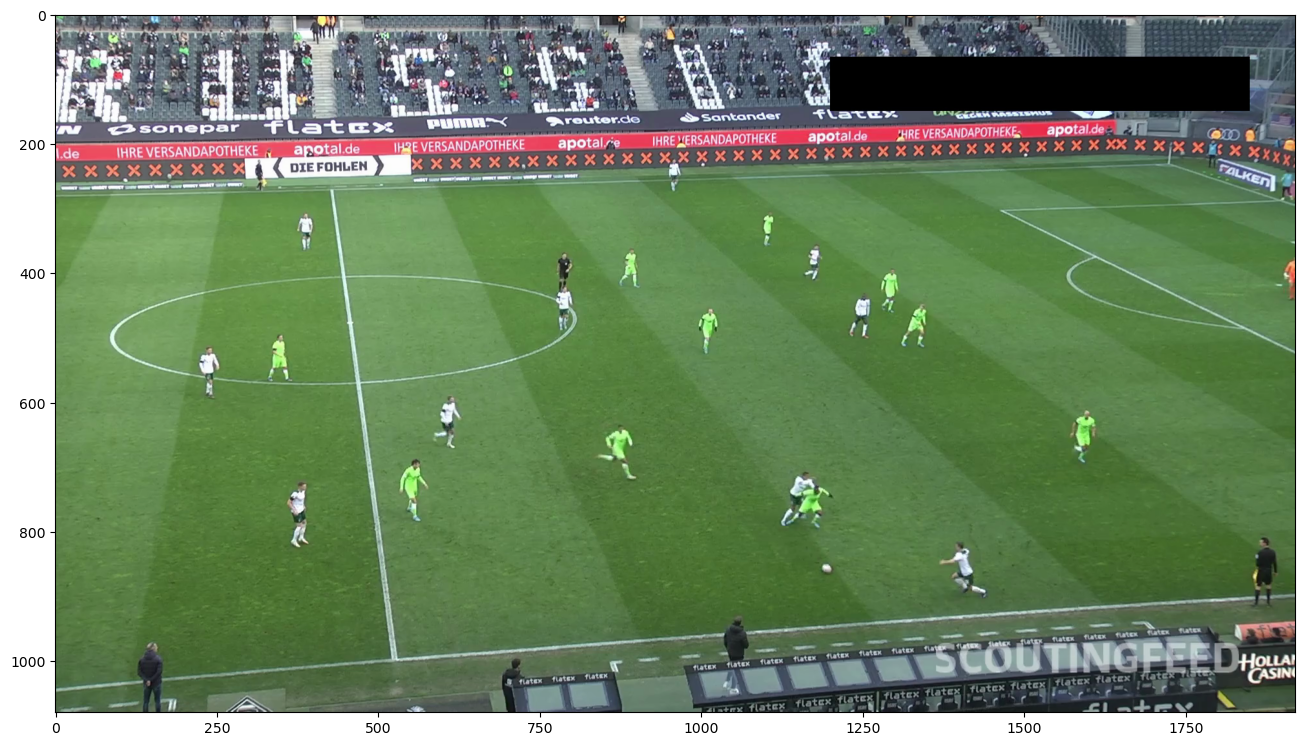

In [9]:
frame = next(frame_iterator)
plot_image(frame, 16)

In [12]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', WEIGHTS_PATH, device='cpu')

Using cache found in /Users/sakshambehal/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-3-23 Python-3.11.7 torch-2.2.1 CPU

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
Adding AutoShape... 


In [13]:
results = model(frame, size=1280)

In [14]:
results.pandas()

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 1080x1920 1 ball, 1 goalkeeper, 19 players, 3 referees
Speed: 28.4ms pre-process, 5252.8ms inference, 3.3ms NMS per image at shape (1, 3, 768, 1280)

In [15]:
results.pred[0]

tensor([[5.33241e+02, 6.87589e+02, 5.78537e+02, 7.84716e+02, 9.73716e-01, 2.00000e+00],
        [1.36860e+03, 8.16073e+02, 1.44461e+03, 9.04895e+02, 9.72140e-01, 2.00000e+00],
        [3.27608e+02, 4.94238e+02, 3.67631e+02, 5.70032e+02, 9.71972e-01, 2.00000e+00],
        [1.30964e+03, 4.47082e+02, 1.35071e+03, 5.16324e+02, 9.67740e-01, 2.00000e+00],
        [8.47948e+02, 6.34089e+02, 9.00749e+02, 7.21372e+02, 9.66541e-01, 2.00000e+00],
        [1.85379e+03, 8.07012e+02, 1.89348e+03, 9.18147e+02, 9.66216e-01, 3.00000e+00],
        [2.21991e+02, 5.13463e+02, 2.55613e+02, 5.94487e+02, 9.64073e-01, 2.00000e+00],
        [1.57270e+03, 6.11390e+02, 1.61233e+03, 6.94797e+02, 9.62561e-01, 2.00000e+00],
        [9.96135e+02, 4.54196e+02, 1.02639e+03, 5.26416e+02, 9.62461e-01, 2.00000e+00],
        [1.12392e+03, 7.07827e+02, 1.18118e+03, 7.92834e+02, 9.62215e-01, 2.00000e+00],
        [1.22949e+03, 4.31626e+02, 1.26350e+03, 5.01704e+02, 9.61982e-01, 2.00000e+00],
        [8.73527e+02, 3.61281e+0

In [16]:
model.names

{0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}

## Install ByteTrack and other libs<a class="anchor" id="install-bytetrack"></a>

ByteTrack is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with YOLOv5.  

In [73]:
%cd {HOME}
!cd ByteTrack && \
pip3 install -r requirements.txt && \
python setup.py develop

/Users/sakshambehal/Documents/Research_Papers
  Using cached ninja-1.11.1.1-py2.py3-none-macosx_10_9_universal2.macosx_10_9_x86_64.macosx_11_0_arm64.macosx_11_0_universal2.whl.metadata (5.3 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Using cached motmetrics-1.4.0-py3-none-any.whl.metadata (20 kB)
  Using cached filterpy-1.4.5-py3-none-any.whl
  Using cached onnxruntime-1.17.1-cp311-cp311-macosx_11_0_universal2.whl.metadata (4.2 kB)
  Using cached onnx_simplifier-0.3.5-py3-none-any.whl
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached flatbuffers-24.3.7-py2.py3-none-any.whl.metadata (849 bytes)
  Using cached onnxoptimizer-0.3.13-cp311-cp311-macosx_10_15_universal2.whl.metadata (3.2 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached grpcio-1.62.1-cp311-cp311-macosx_10_10_universal2.whl.metadata (4.0 kB)
  Us

In [61]:
!pip install lap

  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [169 lines of output]
      /private/var/folders/6y/q_4j63613pz0v6xvwhm2300c0000gn/T/pip-install-92t2_06u/lap_f2159a74e9a04364a3170241b900d4f3/setup.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        from pkg_resources import parse_version
      Partial import of lap during the build process.
      /private/var/folders/6y/q_4j63613pz0v6xvwhm2300c0000gn/T/pip-install-92t2_06u/lap_f2159a74e9a04364a3170241b900d4f3/setup.py:223: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setup

In [18]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

In [19]:
!pip install onemetric --quiet

In [22]:
pip install lap

  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [169 lines of output]
      /private/var/folders/6y/q_4j63613pz0v6xvwhm2300c0000gn/T/pip-install-t8y5n11c/lap_6da1405bcdb44ae48ed1976c99511a6f/setup.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        from pkg_resources import parse_version
      Partial import of lap during the build process.
      /private/var/folders/6y/q_4j63613pz0v6xvwhm2300c0000gn/T/pip-install-t8y5n11c/lap_6da1405bcdb44ae48ed1976c99511a6f/setup.py:223: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setup

In [20]:
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [25]:

from onemetric.cv.utils.iou import box_iou_batch

In [27]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
#not working (need to have a look at how to install lap)

ModuleNotFoundError: No module named 'lap'

In [42]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [47]:
git clone https://github.com/gatagat/lap.git

SyntaxError: invalid syntax (1181769801.py, line 1)

## Custom annotator <a class="anchor" id="custom-annotator"></a>

In [28]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

import cv2

import numpy as np


# geometry utilities


@dataclass(frozen=True)
class Point:
    x: float
    y: float
    
    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x
    
    @property
    def min_y(self) -> float:
        return self.y
    
    @property
    def max_x(self) -> float:
        return self.x + self.width
    
    @property
    def max_y(self) -> float:
        return self.y + self.height
        
    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)
    
    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding, 
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )
    
    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities


@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result


def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection 
        in detections
        if detection.class_name == class_name
    ]


# draw utilities


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int
        
    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
    return image


def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.ellipse(
        image,
        center=rect.bottom_center.int_xy_tuple,
        axes=(int(rect.width), int(0.35 * rect.width)),
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


# base annotator
  

@dataclass
class BaseAnnotator:
    colors: List[Color]
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_ellipse(
                image=image,
                rect=detection.rect,
                color=self.colors[detection.class_id],
                thickness=self.thickness
            )
        return annotated_image

In [29]:
# white
BALL_COLOR_HEX = "#FFFFFF"
BALL_COLOR = Color.from_hex_string(BALL_COLOR_HEX)

# red
GOALKEEPER_COLOR_HEX = "#850101"
GOALKEEPER_COLOR = Color.from_hex_string(GOALKEEPER_COLOR_HEX)

# green
PLAYER_COLOR_HEX = "#00D4BB"
PLAYER_COLOR = Color.from_hex_string(PLAYER_COLOR_HEX)

# yellow
REFEREE_COLOR_HEX = "#FFFF00"
REFEREE_COLOR = Color.from_hex_string(REFEREE_COLOR_HEX)

COLORS = [
    BALL_COLOR,
    GOALKEEPER_COLOR,
    PLAYER_COLOR,
    REFEREE_COLOR
]
THICKNESS = 4

In [30]:
# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

In [31]:
# initiate annotators
annotator = BaseAnnotator(
    colors=COLORS, 
    thickness=THICKNESS)

# acquire video frame
frame = next(frame_iterator)

# run detector
results = model(frame, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(), 
    names=model.names)

# annotate video frame
annotated_image = annotator.annotate(
    image=frame, 
    detections=detections)

# plot video frame
plot_image(annotated_image, 16)

## Detect ball possession <a class="anchor" id="detect-ball-possession"></a>


We want to mark current ball location as well as player currently in possession with small triangle markers. 

### Utils

In [32]:
# black
MARKER_CONTOUR_COLOR_HEX = "000000"
MARKER_CONTOUR_COLOR = Color.from_hex_string(MARKER_CONTOUR_COLOR_HEX)

# red
PLAYER_MARKER_FILL_COLOR_HEX = "FF0000"
PLAYER_MARKER_FILL_COLOR = Color.from_hex_string(PLAYER_MARKER_FILL_COLOR_HEX)

# green
BALL_MERKER_FILL_COLOR_HEX = "00FF00"
BALL_MARKER_FILL_COLOR = Color.from_hex_string(BALL_MERKER_FILL_COLOR_HEX)

MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
MARKER_MARGIN = 10

# distance in pixels from the player's bounding box where we consider the ball is in his possession
PLAYER_IN_POSSESSION_PROXIMITY = 30

In [33]:
from typing import List

import numpy as np


# calculates coordinates of possession marker
def calculate_marker(anchor: Point) -> np.ndarray:
    x, y = anchor.int_xy_tuple
    return(np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ]))


# draw single possession marker
def draw_marker(image: np.ndarray, anchor: Point, color: Color) -> np.ndarray:
    possession_marker_countour = calculate_marker(anchor=anchor)
    image = draw_filled_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=color)
    image = draw_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=MARKER_CONTOUR_COLOR,
        thickness=MARKER_CONTOUR_THICKNESS)
    return image


# dedicated annotator to draw possession markers on video frames
@dataclass
class MarkerAnntator:

    color: Color

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_marker(
                image=image, 
                anchor=detection.rect.top_center,
                color=self.color)
        return annotated_image

In [34]:
from typing import List, Optional


# resolves which player is currently in ball possession based on player-ball proximity
def get_player_in_possession(
    player_detections: List[Detection], 
    ball_detections: List[Detection],
    proximity: int
) -> Optional[Detection]:
    if len(ball_detections) != 1:
        return None
    ball_detection = ball_detections[0]
    for player_detection in player_detections:
        if player_detection.rect.pad(proximity).contains_point(point=ball_detection.rect.center):
            return player_detection

### Single frame

In [35]:
# initiate annotators
ball_marker_annotator = MarkerAnntator(color=BALL_MARKER_FILL_COLOR)
player_marker_annotator = MarkerAnntator(color=PLAYER_MARKER_FILL_COLOR)

# acquire video frame
frame = next(frame_iterator)

# run detector
results = model(frame, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(), 
    names=model.names)

# postprocess results
ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
player_detections = filter_detections_by_class(detections=detections, class_name="player")
player_in_possession_detection = get_player_in_possession(
    player_detections=player_detections,
    ball_detections=ball_detections,
    proximity=PLAYER_IN_POSSESSION_PROXIMITY)

# annotate video frame
annotated_image = frame.copy()
annotated_image = ball_marker_annotator.annotate(
    image=annotated_image, 
    detections=ball_detections)
annotated_image = player_marker_annotator.annotate(
    image=annotated_image, 
    detections=[player_in_possession_detection] if player_in_possession_detection else [])

# plot video frame
plot_image(annotated_image, 16)

### Full video

In [36]:
# settings
SOURCE_VIDEO_PATH = f"{HOME}/clips/08fd33_4.mp4"
TARGET_VIDEO_PATH = f"{HOME}/ball-possession/8fd33_4.mp4"

In [37]:
from dataclasses import dataclass

import cv2


"""
usage example:

video_config = VideoConfig(
    fps=30, 
    width=1920, 
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

for frame in frames:
    ...
    video_writer.write(frame)
    
video_writer.release()
"""


# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int
        

# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path, 
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
        fps=video_config.fps, 
        frameSize=(video_config.width, video_config.height), 
        isColor=True
    )

## Full video tracking <a class="anchor" id="full-video-tracking"></a>

In [38]:
# settings
SOURCE_VIDEO_PATH = f"{HOME}/clips/08fd33_4.mp4"
TARGET_VIDEO_PATH = f"{HOME}/tracking/8fd33_4.mp4"

In [39]:
from typing import List

import numpy as np

"""
BYTETracker does not assign tracker_id to existing bounding boxes but rather
predicts the next bounding box position based on previous one. Therefore, we 
need to find a way to match our bounding boxes with predictions.

usage example:

byte_tracker = BYTETracker(BYTETrackerArgs())
for frame in frames:
    ...
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(), 
        names=model.names)
    ...
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape)
    detections = match_detections_with_tracks(detections=detections, tracks=tracks)
"""

# converts List[Detection] into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x, 
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x, 
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: List[Detection], 
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

In [40]:
# text annotator to display tracker_id
@dataclass
class TextAnnotator:
    background_color: Color
    text_color: Color
    text_thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            # if tracker_id is not assigned skip annotation
            if detection.tracker_id is None:
                continue

            # calculate text dimensions
            size, _ = cv2.getTextSize(
                str(detection.tracker_id), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.7, 
                thickness=self.text_thickness)
            width, height = size
            
            # calculate text background position
            center_x, center_y = detection.rect.bottom_center.int_xy_tuple
            x = center_x - width // 2
            y = center_y - height // 2 + 10
            
            # draw background
            annotated_image = draw_filled_rect(
                image=annotated_image, 
                rect=Rect(x=x, y=y, width=width, height=height).pad(padding=5), 
                color=self.background_color)
            
            # draw text
            annotated_image = draw_text(
                image=annotated_image, 
                anchor=Point(x=x, y=y + height), 
                text=str(detection.tracker_id), 
                color=self.text_color, 
                thickness=self.text_thickness)
        return annotated_image

In [41]:
from tqdm.notebook import tqdm

# initiate video writer
video_config = VideoConfig(
    fps=30, 
    width=1920, 
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

# initiate annotators
text_annotator = TextAnnotator(background_color=Color(255, 255, 255), text_color=Color(0, 0, 0), text_thickness=2)

# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs())

# loop over frames
for frame in tqdm(frame_iterator, total=750):

    # run detector
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(), 
        names=model.names)

    # postprocess results
    goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
    player_detections = filter_detections_by_class(detections=detections, class_name="player")
    player_detections = player_detections + goalkeeper_detections
    
    # track players
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=player_detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    player_detections = match_detections_with_tracks(detections=player_detections, tracks=tracks)

    # annotate video frame
    annotated_image = frame.copy()
    annotated_image = text_annotator.annotate(
        image=annotated_image, 
        detections=player_detections)
    
    # save video frame
    video_writer.write(annotated_image)

# close output video
video_writer.release()

NameError: name 'BYTETracker' is not defined

## Put everything together <a class="anchor" id="put-everything-together"></a>

In [54]:
# settings
# SOURCE_VIDEO_PATH = f"{HOME}/clips/0a2d9b_0.mp4"
# TARGET_VIDEO_PATH = f"{HOME}/final/0a2d9b_0.mp4"

SOURCE_VIDEO_PATH = f"{HOME}/clips/08fd33_4.mp4"
TARGET_VIDEO_PATH = f"{HOME}/final/08fd33_4.mp4"

In [55]:
from tqdm.notebook import tqdm

# initiate video writer
video_config = VideoConfig(
    fps=30, 
    width=1920, 
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

# initiate annotators
base_annotator = BaseAnnotator(
    colors=[
        BALL_COLOR,
        PLAYER_COLOR,
        PLAYER_COLOR,
        REFEREE_COLOR
    ], 
    thickness=THICKNESS)

player_goalkeeper_text_annotator = TextAnnotator(
    PLAYER_COLOR, text_color=Color(255, 255, 255), text_thickness=2)
referee_text_annotator = TextAnnotator(
    REFEREE_COLOR, text_color=Color(0, 0, 0), text_thickness=2)

ball_marker_annotator = MarkerAnntator(
    color=BALL_MARKER_FILL_COLOR)
player_in_possession_marker_annotator = MarkerAnntator(
    color=PLAYER_MARKER_FILL_COLOR)


# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs())

# loop over frames
for frame in tqdm(frame_iterator, total=750):

    # run detector
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(), 
        names=model.names)
    
    # filter detections by class
    ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
    referee_detections = filter_detections_by_class(detections=detections, class_name="referee")
    goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
    player_detections = filter_detections_by_class(detections=detections, class_name="player")
    
    player_goalkeeper_detections = player_detections + goalkeeper_detections
    tracked_detections = player_detections + goalkeeper_detections + referee_detections

    # calculate player in possession
    player_in_possession_detection = get_player_in_possession(
        player_detections=player_goalkeeper_detections,
        ball_detections=ball_detections,
        proximity=PLAYER_IN_POSSESSION_PROXIMITY)

    # track
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=tracked_detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracked_detections = match_detections_with_tracks(detections=tracked_detections, tracks=tracks)

    tracked_referee_detections = filter_detections_by_class(detections=tracked_detections, class_name="referee")
    tracked_goalkeeper_detections = filter_detections_by_class(detections=tracked_detections, class_name="goalkeeper")
    tracked_player_detections = filter_detections_by_class(detections=tracked_detections, class_name="player")

    # annotate video frame
    annotated_image = frame.copy()
    annotated_image = base_annotator.annotate(
        image=annotated_image, 
        detections=tracked_detections)
    
    annotated_image = player_goalkeeper_text_annotator.annotate(
        image=annotated_image, 
        detections=tracked_goalkeeper_detections + tracked_player_detections)
    annotated_image = referee_text_annotator.annotate(
        image=annotated_image, 
        detections=tracked_referee_detections)
    
    annotated_image = ball_marker_annotator.annotate(
        image=annotated_image, 
        detections=ball_detections)
    annotated_image = player_marker_annotator.annotate(
        image=annotated_image, 
        detections=[player_in_possession_detection] if player_in_possession_detection else [])

    # save video frame
    video_writer.write(annotated_image)

# close output video
video_writer.release()

  0%|          | 0/750 [00:00<?, ?it/s]